# Anexos 

## Usando Cython fuera de Jupyter

El código cython se guarda tipicamente con extensión `pyx`. Cuando hacemos 

    cython -3 codigo.pyx
    
se genera un código en lenguaje C. La opción `-3` indica compatibilidad con Python 3

In [1]:
!cython -3 src/fractal_cython.pyx

Luego usamos nuestro compilador de C preferido apuntando adecuadamente a las cabeceras y librerías de Python 3 (y en este caso de NumPy también)

Se debe generar una libreria compartida (shared)

Por ejemplo con gcc

In [2]:
%%bash
export my_conda_env="/home/phuijse/.conda/envs/info147"
export python_path=${my_conda_env}"/include/python3.8"
export numpy_path=${my_conda_env}"/lib/python3.8/site-packages/numpy/core/include"
gcc -shared -pthread -fPIC -fwrapv -O2 -Wall -fno-strict-aliasing -I${python_path} -I${numpy_path} -L/usr/lib -lm -lpython3  src/fractal_cython.c -o fractal_cython.so
ls fractal_*

In file included from /home/phuijse/.conda/envs/info147/lib/python3.8/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969,
                 from /home/phuijse/.conda/envs/info147/lib/python3.8/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/phuijse/.conda/envs/info147/lib/python3.8/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from src/fractal_cython.c:681:
/home/phuijse/.conda/envs/info147/lib/python3.8/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~


fractal_cython.so


Luego podemos importar la librería como un módulo de Python cualquiera

In [3]:
%load_ext autoreload 
%autoreload 2
import numpy as np
from fractal_cython import make_fractal_cython as make_fractal_imported

In [4]:
N = 2000
image_cython_imported = np.empty(shape=(N, 2*N), dtype=np.int64)
%timeit -r3 -n1 make_fractal_imported(N, image_cython_imported)

493 ms ± 17.6 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


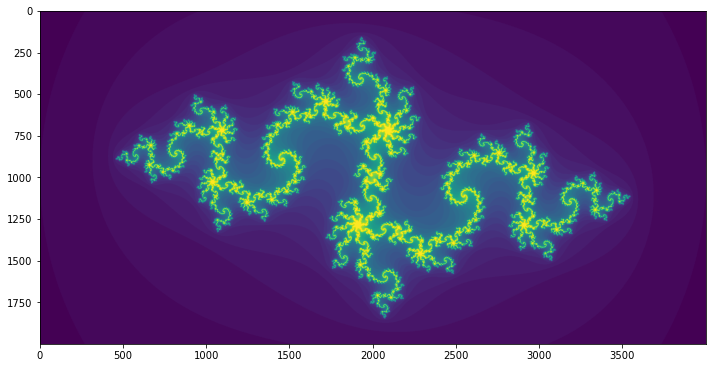

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

make_fractal_imported(N, image_cython_imported)
fig, ax = plt.subplots(figsize=(10, 6), tight_layout=True)
ax.imshow(image_cython_imported);

Limpiamos los archivos compilados si ya no son necesarios:

In [6]:
!rm src/fractal_cython.c fractal_cython.so

## Compilación Just-in-time (JIT) con [Numba](http://numba.pydata.org/)

Podemos acelerar cálculos científicos de forma simple y semi-automática usando el compilador **Numba**. Este compilador no requiere cambiar el interprete de Python y tampoco es necesario aprender otro lenguaje

A través de decoradores podemos pedirle a Numba que compile una función "al vuelo" (just-in-time). Internamente Numba traduce las funciones de Python a lenguaje de máquina usando el compilador [LLVM](https://llvm.org/)

Para "ciertas funciones" el resultado será una versión compilada notoriamente más rápida en su ejecución que la original. Numba está diseñado para hacer más eficiente rutinas *compute-bound* que hagan **cálculos numéricos**. Tiene soporte para compilar funciones de Numpy y para paralelizar automaticamente ciclos `for`

Instalación utilizando conda:

    conda install numba

A continuación veremos los decoradores fundamentales de *Numba* y algunos ejemplos

Volvamos al código vectorizado para calcular la distancia euclidiana "todos con todos"

In [7]:
import numpy as np

data = np.random.randn(1000, 2)

def distancia_pares_numpy(data):
    return np.sqrt(np.sum((data.reshape(-1, 1, 2) - data.reshape(1, -1, 2))**2, axis=-1))

time_numpy = %timeit -r3 -n1 -o distancia_pares_numpy(data)

67.2 ms ± 1.6 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Se utiliza numba para acelerar el cálculo de esta función:

- Importamos el decorador `jit` y lo aplicamos a la función anterior
- Usaremos el modo `nopython` o "modo rápido", esto indica al compilador que la función no usará el interprete de Python
- La primera llamada a la función es lenta, pues acciona el compilador
- La siguientes llamadas son más rápidas que la función de NumPy

In [8]:
from numba import jit

@jit(nopython=True)
def distancia_pares_numba(data):
    return np.sqrt(np.sum((data.reshape(-1, 1, 2) - data.reshape(1, -1, 2))**2, axis=-1))

distancia_pares_numba(data) # Aquí se ejecuta la compilación

time_numba = %timeit -r3 -n1 -o distancia_pares_numba(data)

19.6 ms ± 96.3 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [9]:
time_numpy.average/time_numba.average

3.425967328204648

In [10]:
np.allclose(distancia_pares_numpy(data), distancia_pares_numba(data))

True

- Existe un alias para `jit(nopython=True)` llamado `njit`
- Otros argumentos interesantes para decorar son: `parallel=True` y `fastmath=True` 

:::{note}

No todas las [funcionalidades y funciones de NumPy están soportadas](https://numba.pydata.org/numba-doc/latest/reference/numpysupported.html)

:::

Por ejemplo en la función `make_fractal_vectorized` al intentar numbificar existen varios errores

- `linspace` sólo soporta la versión con tres argumentos
- `repeat` no acepta el argumento `axis`
- *fancy-indexing* en arreglos 2D no está soportado por lo que `image[mask] +=1` no funciona

En este caso podriamos intentar "numbificar" la versión no vectorizada

In [11]:
from numba import njit

@njit
def evaluate_numba(zi, zr, maxiters=50, cr=-0.835, ci=-0.2321):
    nit = 0
    zi2 = zi*zi
    zr2 = zr*zr
    while zi2 + zr2 <= 4. and nit < maxiters:
        zi = 2*zr*zi + ci
        zr = zr2 - zi2 + cr
        zr2 = zr*zr
        zi2 = zi*zi
        nit +=1
    return nit

@njit
def make_fractal_numba(N, maxiters=50):
    image = []
    for i in range(N):
        row = []
        for j in range(2*N):
            zi = -1.0 + i*2/N
            zr = -2.0 + j*2/N
            row.append(evaluate_numba(zi, zr, maxiters))
        image.append(row)
    return image


%timeit -r3 -n1 make_fractal_numba(N)

773 ms ± 140 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
